In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("../imagenet/images/train/n01440764/n01440764_1775.JPEG")

# plt.figure(figsize=(16, 8))
# plt.subplot(121)
# plt.title("Image")
# plt.imshow(image.permute(1, 2, 0))

In [2]:
import os

paths=[]
labels=[]
feature_id = []
count = 0
for dirname, _, filenames in os.walk('../imagenet/images/train'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            paths+=[(os.path.join(dirname, filename))]
            feature_id+=[(os.path.join(dirname, filename))[len("../imagenet/images/train")+1:]]
            label=dirname.split('/')[-1]
            labels+=[label]
            if os.path.isfile("../imagenet/bboxes_annotations/"+(os.path.join(dirname, filename))[len("../imagenet/images/train")+1:][:-4]+"xml") == False:
                paths.pop()
                feature_id.pop()
                labels.pop()
                count += 1
                print((os.path.join(dirname, filename))[len("../imagenet/images/train")+1:][:-4]+"xml")

print(len(paths))
print(count)
            
tpaths=[]
tlabels=[]
for dirname, _, filenames in os.walk('../imagenet/images/val'):
    for filename in filenames:
        if filename[-4:]=='JPEG':
            tpaths+=[(os.path.join(dirname, filename))]
            label=dirname.split('/')[-1]
            tlabels+=[label]

all_labels=os.listdir('../imagenet/images/train')
# for dirname, _, filenames in os.walk('../imagenet/images/train'):
#     for filename in filenames:
#         if filename[-3:]=='xml':
#             ann_paths+=[(os.path.join(dirname, filename))]

print(len(all_labels))

n04542943/n04542943_594.xml
n04542943/n04542943_1610.xml
n04542943/n04542943_1702.xml
n04542943/n04542943_371.xml
n04542943/n04542943_2948.xml
n04542943/n04542943_672.xml
n04542943/n04542943_2748.xml
n04542943/n04542943_10587.xml
n04542943/n04542943_10250.xml
n04542943/n04542943_6736.xml
n04542943/n04542943_1944.xml
n04542943/n04542943_4069.xml
n04542943/n04542943_9509.xml
n04542943/n04542943_2522.xml
n04542943/n04542943_2871.xml
n04542943/n04542943_3737.xml
n04542943/n04542943_5285.xml
n04542943/n04542943_4046.xml
n04542943/n04542943_1481.xml
n04542943/n04542943_5267.xml
n04542943/n04542943_10448.xml
n04542943/n04542943_4386.xml
n04542943/n04542943_4144.xml
n04542943/n04542943_8669.xml
n04542943/n04542943_7303.xml
n02795169/n02795169_17500.xml
n02795169/n02795169_19590.xml
n02795169/n02795169_59073.xml
n02795169/n02795169_4774.xml
n02795169/n02795169_15834.xml
n02795169/n02795169_39392.xml
n02795169/n02795169_30012.xml
n02795169/n02795169_27684.xml
n02795169/n02795169_4657.xml
n027951

In [3]:
from torchvision.transforms import v2 as T

# /Users/ronaksingh/Documents/Github/NGHackathon24/imagenet/bboxes_annotations/n04107743/n00141669_73.xml

def get_transform(train):
    transforms = []
    if train:
        # transforms.append(T.RandomResizedCrop(size=(224, 224), antialias=True))
        # transforms.append(T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)))
        # transforms.append(T.RandomPhotometricDistort(0.5))
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    # transforms.append(T.TenCrop(32)) # this is a tuple of PIL Images
    # transforms.append(T.Lambda(lambda crops: torch.stack([T.PILToTensor()(crop) for crop in crops]))),
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [4]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import xml.etree.ElementTree as ET
from torchvision.datasets import ImageNet
from torch.utils.data import DataLoader

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# labelsMaster = ["bg", "Musical keyboard", "Piano", "Wheel", "Car", "Mirror", "Clothing", "Chair", "Ladder", "Music stand", "Table", "Chair", "Building (group)", "Drink (group)", "Shelf", "Book", "Book (group)", "Camera", "Drink", "Desk", "Human arm", "Human hair", "Human leg", "Human hand", "Watch", "Screen", "Woman"]


def read_pascal_voc_annotation(xml_file):
    # tree = ET.parse(xml_file, parser = ET.XMLParser(encoding = 'iso-8859-5'))
    # print(xml_file)
    tree = ET.parse(xml_file)

    root = tree.getroot()

    annotations = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)
        label = obj.find('name').text

        annotations.append({
            'bbox': [xmin, ymin, xmax, ymax],
            'label': label
        })

    return annotations

# print(read_pascal_voc_annotation('../imagenet/bboxes_annotations/n01440764/n01440764_1775.xml'))

# imagenet_train = ImageNet(root="../imagenet/images/train/", split='train', transform=get_transform(train=True))


class ImageNetDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        # self.imgs = list(sorted(os.listdir(os.path.join(root, "JPGImages"))))
        # self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        self.imgs = paths
        self.annotations = feature_id
        # self.annotations = ann_paths

    def __getitem__(self, idx):
        # load images and masks
        # img_path = os.path.join(self.root, "JPGImages", self.imgs[idx])
        # annotation_path = os.path.join(self.root, "Annotations", self.annotations[idx])
        img_path = self.imgs[idx]
        annotation_path = os.path.join(self.root, "bboxes_annotations", (self.annotations[idx][:-4]+"xml"))
        img = read_image(img_path)

        # print(img_path)
        
        annotation_out = read_pascal_voc_annotation(annotation_path)

        # instances are encoded as different colors
        # obj_ids = torch.unique(img)
        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]
        num_objs = len(annotation_out)

        # print(num_objs)

        # split the color-encoded mask into a set
        # of binary masks
        # masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        # boxes = masks_to_boxes(masks)
        # boxesList = [a["bbox"] for a in annotation_out]
        boxesList = []
        # boxes = torch.tensor(np.array(boxesList), dtype=float)

        # there is only one class
        # labels = torch.ones((num_objs,), dtype=torch.int64)

        # labelList = [labelsMaster.index(a["label"]) for a in annotation_out]

        # labelList = [labels.index(a["label"]) for a in annotation_out]
        labelList = []

        for a in annotation_out:
            if a["label"] in all_labels:
                labelList += [all_labels.index(a["label"])+1]
                boxesList += [a["bbox"]]

        boxes = torch.tensor(np.array(boxesList), dtype=float)
        
        tensorLabel = torch.tensor(np.array(labelList), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = tensorLabel
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # print(target["boxes"].long())

        # image = (255.0 * (img - img.min()) / (img.max() - img.min())).to(torch.uint8)
        # image = image[:3, ...]
        # pred_labels = [f"{label}" for label in target["labels"]]
        # # pred_labels = [f"person"]
        # pred_boxes = target["boxes"].long()
        # output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
        # # print(output_image)

        # # plt.figure(figsize=(12, 12))
        # plt.imshow(output_image.permute(1, 2, 0))

        # print(target["boxes"])

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.score_thresh = 0

    return model

model = get_model_instance_segmentation(len(all_labels)+1)

In [12]:
all_labels[377]
# all_labels.index("n02423022")

'n03042490'

../imagenet/images/train/n02423022/n02423022_559.JPEG
../imagenet/images/train/n02423022/n02423022_559.JPEG


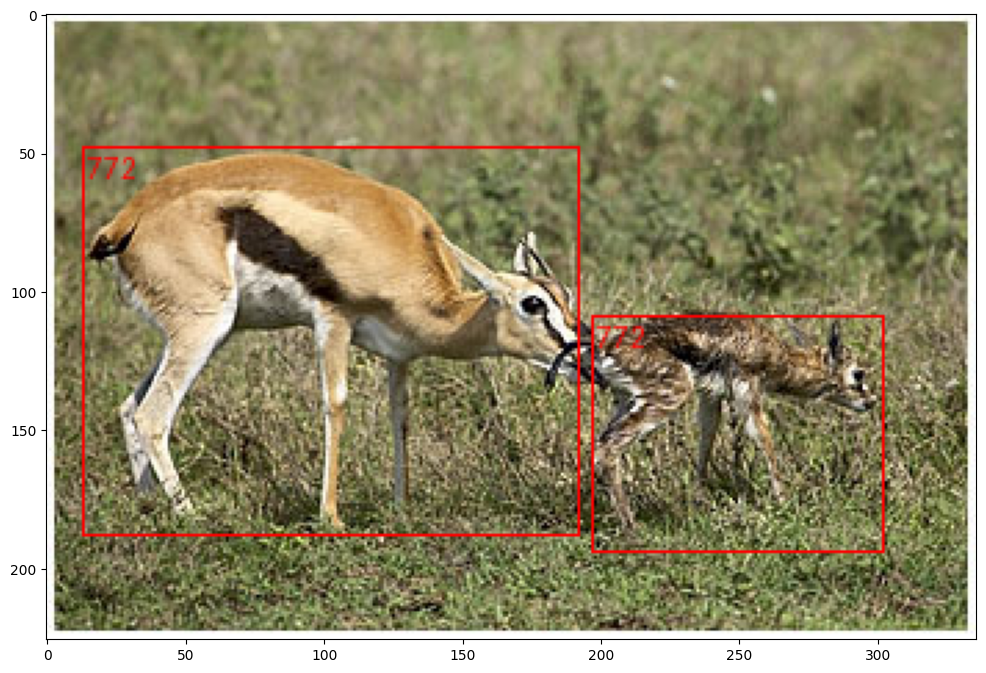

In [16]:
dataset = ImageNetDataset('../imagenet', get_transform(train=False))

image = dataset[10010][0]
pred = dataset[10010][1]

# pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label-1}" for label in pred["labels"]]
# pred_labels = [f"person"]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [14]:
import math
import utils
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from engine import train_one_epoch, evaluate


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = ImageNetDataset('../imagenet', get_transform(train=True))
dataset_test = ImageNetDataset('../imagenet', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[:-50])
dataset = torch.utils.data.Subset(dataset, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
#     model.train()
#     metric_logger = utils.MetricLogger(delimiter="  ")
#     metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
#     header = f"Epoch: [{epoch}]"

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )

#     for images, targets in metric_logger.log_every(data_loader, print_freq, header):
#         # print(images)
#         images = list(image.to(device) for image in images)
#         targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
#         print(targets)
#         with torch.cuda.amp.autocast(enabled=scaler is not None):
#             loss_dict = model(images, targets)
#             print(loss_dict)
#             losses = sum(loss for loss in loss_dict.values())

#         # reduce losses over all GPUs for logging purposes
#         loss_dict_reduced = utils.reduce_dict(loss_dict)
#         losses_reduced = sum(loss for loss in loss_dict_reduced.values())

#         loss_value = losses_reduced.item()

#         if not math.isfinite(loss_value):
#             print(f"Loss is {loss_value}, stopping training")
#             print(loss_dict_reduced)
#             sys.exit(1)

#         optimizer.zero_grad()
#         if scaler is not None:
#             scaler.scale(losses).backward()
#             scaler.step(optimizer)
#             scaler.update()
#         else:
#             losses.backward()
#             optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#         metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
#         metric_logger.update(lr=optimizer.param_groups[0]["lr"])

#     return metric_logger

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = 5

# best_vloss = 1_000_000.

model.to(device)
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    torch.save(model.state_dict(), f'imagenet_finetune_weights_f{epoch}.pth')
#     # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    # torch.save(model.state_dict(), f'imagenet_finetune_weights_{epoch}.pth')

# torch.save(model.state_dict(), 'test_finetune_weights.pth')
print("That's it!")

/Users/ronaksingh/Documents/Github/NGHackathon24/ronak_learning/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/50]  eta: 0:14:48  lr: 0.000021  loss: 0.3943 (0.3943)  loss_classifier: 0.2654 (0.2654)  loss_box_reg: 0.0839 (0.0839)  loss_objectness: 0.0110 (0.0110)  loss_rpn_box_reg: 0.0341 (0.0341)  time: 17.7749  data: 0.0528


KeyboardInterrupt: 

tensor([0.0018, 0.0016, 0.0015, 0.0015, 0.0015, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0014, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011])


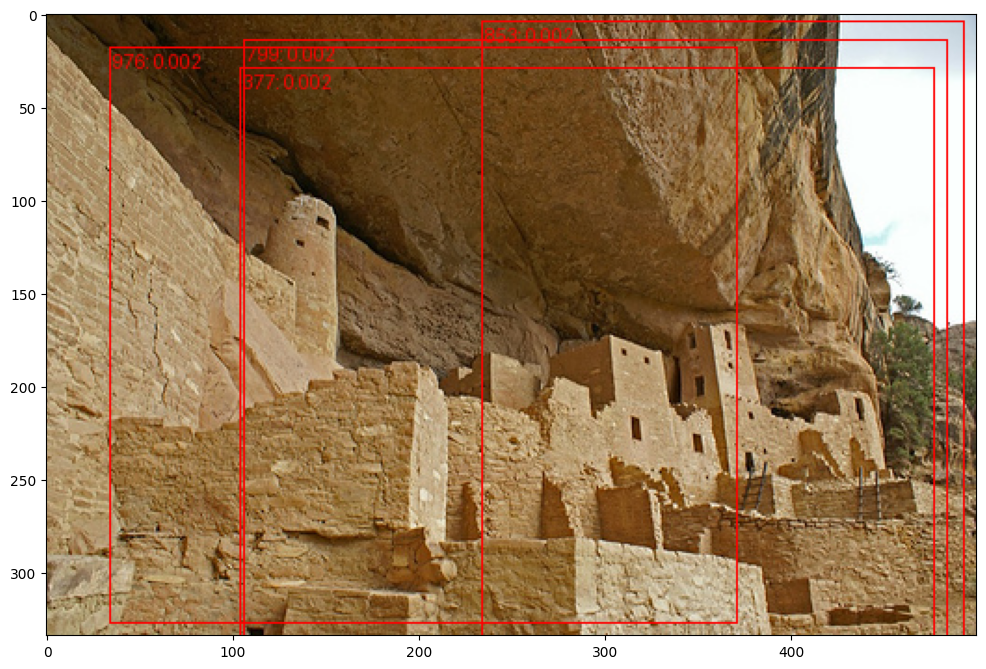

In [13]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

model.eval()

# image = read_image("PennFudanPed/PNGImages/PennPed00096.png")
image = read_image("../imagenet/images/train/n03042490/n03042490_1265.JPEG")
eval_transform = get_transform(train=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# model = get_model_instance_segmentation(34745)
# model.load_state_dict(torch.load("imagenet_finetune_weights.pth", weights_only=True))
# model.eval()

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    # print(x)
    predictions = model([x, ])
    print(predictions[0]["scores"])
    predRaw = predictions[0]

idxOfClass = [i for i, x in enumerate(list(predRaw['scores'])) if x > 0.0015]
# print(idxOfClass)
# pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'masks': predRaw['masks'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels = [f"person"]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [8]:
import math
import utils
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from engine import train_one_epoch, evaluate


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = ImageNetDataset('../imagenet', get_transform(train=True))
dataset_test = ImageNetDataset('../imagenet', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_test = torch.utils.data.Subset(dataset_test, indices[:len(dataset)//10])
dataset = torch.utils.data.Subset(dataset, indices[len(dataset)//10:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
# epoch_number = 0

# EPOCHS = 5

# best_vloss = 1_000_000.

model.to(device)
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
#     # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    torch.save(model.state_dict(), f'imagenet_finetune_weights_{epoch}.pth')

# torch.save(model.state_dict(), 'test_finetune_weights.pth')
print("That's it!")

/var/folders/12/lgww1w4s6j31rwtyn8g5db7m0000gn/T/ipykernel_80039/279445382.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [   0/2921]  eta: 1 day, 14:37:02  lr: 0.000010  loss: 10.3886 (10.3886)  loss_classifier: 10.2453 (10.2453)  loss_box_reg: 0.1221 (0.1221)  loss_objectness: 0.0143 (0.0143)  loss_rpn_box_reg: 0.0070 (0.0070)  time: 47.5942  data: 0.0473
Epoch: [0]  [  10/2921]  eta: 1 day, 7:06:11  lr: 0.000060  loss: 10.3305 (10.2999)  loss_classifier: 10.1758 (10.1331)  loss_box_reg: 0.1221 (0.1221)  loss_objectness: 0.0204 (0.0270)  loss_rpn_box_reg: 0.0110 (0.0177)  time: 38.4648  data: 0.0406
Epoch: [0]  [  20/2921]  eta: 1 day, 5:54:57  lr: 0.000110  loss: 9.9145 (9.6758)  loss_classifier: 9.7279 (9.4998)  loss_box_reg: 0.1307 (0.1348)  loss_objectness: 0.0103 (0.0226)  loss_rpn_box_reg: 0.0189 (0.0186)  time: 36.6006  data: 0.0336
Epoch: [0]  [  30/2921]  eta: 1 day, 3:39:49  lr: 0.000160  loss: 7.2576 (7.9590)  loss_classifier: 7.0459 (7.7689)  loss_box_reg: 0.1550 (0.1489)  loss_objectness: 0.0075 (0.0225)  loss_rpn_box_reg: 0.0153 (0.0188)  time: 32.2392  data: 0.0303
Epoch: [0] 

ValueError: 'n04107743' is not in list

In [9]:
torch.save(model.state_dict(), f'imagenet_finetune_weights.pth')

tensor([])


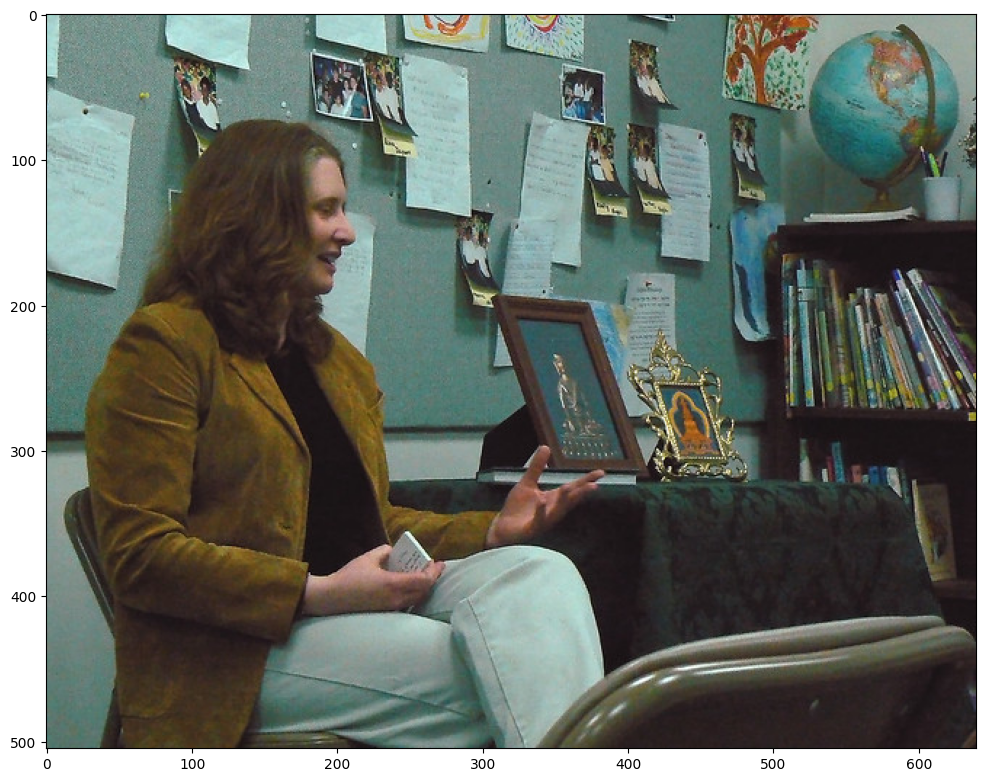

In [16]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# image = read_image("PennFudanPed/PNGImages/PennPed00096.png")
image = read_image("TestData/JPGImages/Image1.jpg")
eval_transform = get_transform(train=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model_instance_segmentation(34745)
model.load_state_dict(torch.load("imagenet_finetune_weights.pth", weights_only=True))
model.eval()

with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    print(predictions[0]["scores"])
    predRaw = predictions[0]

idxOfClass = [i for i, x in enumerate(list(predRaw['scores'])) if x > 0.12]
# print(idxOfClass)
# pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'masks': predRaw['masks'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

pred = {'boxes': predRaw['boxes'][idxOfClass],'labels': predRaw['labels'][idxOfClass],'scores': predRaw['scores'][idxOfClass]}

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_labels = [f"person"]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))